In [1]:
import cv2
import urllib.request as urllib2
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append("../")
from config import config
from linesearch import *

%matplotlib inline

In [2]:
host = config.raspi_ip + ":8080"
hoststr = 'http://' + host + '/?action=stream'
print ('Streaming ' + hoststr)
l_img = []

n_row = 3
n_col = 4

Streaming http://183.172.49.49:8080/?action=stream


# 从摄像头获取 20 张棋盘图，以及一张真实赛道图 （cal0.png）

注意 ret 要为 true

False


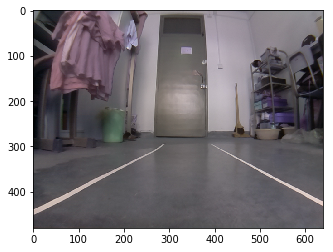

In [3]:
stream=urllib2.urlopen(hoststr)
bytes=b''
while True:
    bytes+=stream.read(1024)
    a = bytes.find(b'\xff\xd8')
    b = bytes.find(b'\xff\xd9')
    if a!=-1 and b!=-1:
        break
        
jpg = bytes[a:b+2]
bytes= bytes[b+2:]
img = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8),flags=1)
img = cv2.flip(img, -1)

plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = (gray<180).astype(np.uint8)*255
ret, corners = cv2.findChessboardCorners(gray, (n_col,n_row), None)
print(ret)
l_img.append(img)

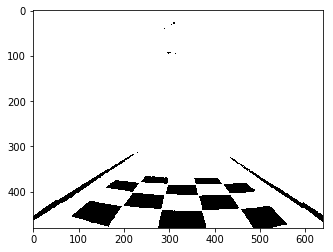

In [32]:
plt.imshow(gray, 'gray')

In [33]:
cv2.imwrite("./calibrateImage/cal0.png", img)

True

# 校正棋盘图

In [34]:
objp = np.zeros((n_row*n_col, 3), np.float32)
objp[:,:2] = np.mgrid[0:n_col, 0:n_row].T.reshape(-1,2)
objpoints = []
imgpoints = []
img_size = (480, 640)

for i in range(21):
    img1 = cv2.imread('./calibrateImage/cal%d.png' % (i))
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray = (gray<180).astype(np.uint8)*255
    ret, corners = cv2.findChessboardCorners(gray, (n_col,n_row), None)
    if ret is True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

In [35]:
ret

1.6362366977261746

# 内参

In [36]:
K = mtx
K

array([[ 344.8387569 ,    0.        ,  261.99495969],
       [   0.        ,   40.75366322,  272.32508764],
       [   0.        ,    0.        ,    1.        ]])

In [37]:
D = dist
D

array([[ -8.65869141e-03,   7.02823862e-04,  -1.41521078e-02,
         -3.54689199e-03,  -1.36307061e-05]])

# 赛道外参 （cal0.png）

In [38]:
R,_ = cv2.Rodrigues(rvecs[0])
R

array([[-0.99177996,  0.08880342, -0.09212197],
       [-0.12690224, -0.59048415,  0.79700959],
       [ 0.01638062,  0.80214863,  0.5968997 ]])

In [39]:
T = tvecs[0]
T

array([[  2.58317313],
       [ 17.38062046],
       [  3.3192616 ]])

In [40]:
x_start = -6
x_end = 14
y_start = -30
y_end = 0
coord_3d = np.float32([
    [x_start, y_start,0],
    [x_start, y_end,  0],
    [x_end,   y_start,0],
    [x_end,   y_end,  0],
]).reshape([-1, 3])


src,jac = cv2.projectPoints(coord_3d, R, T, K, D)
src = src[src[:,0,:].argsort(axis=0)[:,0],0,:]
src = src.reshape([1,4,2])
src.astype(np.int)

array([[[-767,  417],
        [ 158,  198],
        [ 497,  202],
        [ 898,  421]]])

# 直线校正

相机参数校正的 src 有问题，用直线校正。

In [10]:
src = np.array([[
    [0, 430],
    [270,300],
    [400,300],
    [640,420]
]]).astype(np.float32)

dst = np.array([[
    [10,200],
    [10,0],
    [90,0],
    [90,200]
]]).astype(np.float32)

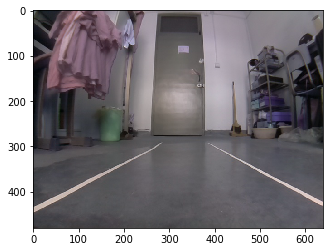

In [11]:
img = cv2.imread("./calibrateImage/cal0.png")
plt.imshow(img)

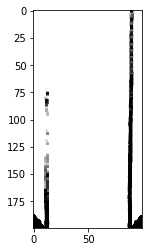

In [14]:
img = cv2.imread('./calibrateImage/cal0.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = (gray<180).astype(np.uint8)*255
    
M    = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_t = cv2.warpPerspective(gray, M, (100,200), cv2.WARP_INVERSE_MAP)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))  
dilated = cv2.erode(img_t,kernel)  

plt.imshow(dilated, 'gray')

# 真实图片

In [12]:
src = np.array([[
    [0, 430],
    [300,300],
    [400,300],
    [640,430]
]]).astype(np.float32)

dst = np.array([[
    [10,200],
    [10,0],
    [90,0],
    [90,200]
]]).astype(np.float32)
M    = cv2.getPerspectiveTransform(src, dst)

initParams = [
        np.linspace(0.001, 0.02, 10),
        np.array(list(np.linspace(1.5, 50, 10)) + list(np.linspace(-50, 1.5, 10))),
        np.arange( 40, 50, 2),
        np.arange(-15, 15, 2)
]
refPos = [50, 180] # The position of the top-center of chess-board on the ground in img_t
    
def imageReadFromraspberryPi(hoststr):
    stream=urllib2.urlopen(hoststr)
    bytes=b''
    while True:
        bytes+=stream.read(1024)
        a = bytes.find(b'\xff\xd8')
        b = bytes.find(b'\xff\xd9')
        if a!=-1 and b!=-1:
            break
        
    jpg = bytes[a:b+2]
    bytes= bytes[b+2:]
    img = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8),flags=1)
    img = cv2.flip(img, -1)
    return img


def perspectTransform(img, M_trans):
    # binarize image for white line
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = (gray<180).astype(np.uint8)*255
    
    # perspectTransform binarized image
    img_t = cv2.warpPerspective(gray, M_trans, (100,200), cv2.WARP_INVERSE_MAP)
    img_t[180:,0:10] = 255
    img_t[180:,90:]  = 255
    return img_t


def processImage(hoststr, M_trans, initParams, refPos):
    seedParams = []
    
    while 1:
        img = imageReadFromraspberryPi(hoststr)
        img_t = perspectTransform(img, M_trans)
        paramSearch = None
        if len(seedParams) == 0:
            paramSearch = initParams
        else:
            lla = np.linspace(seedParams[0]-(initParams[0][1]-initParams[0][0]),
                              seedParams[0]+(initParams[0][1]-initParams[0][0]), 3)
            llb = np.linspace(seedParams[1]-(initParams[1][1]-initParams[1][0]),
                              seedParams[1]+(initParams[1][1]-initParams[1][0]), 3)
            llc = np.arange(seedParams[2]-2, seedParams[2]+3, 2)
            lld = np.arange(seedParams[3]-1, seedParams[3]+2)
            paramSearch = [lla, llb, llc, lld]

        coords,params = getBestParams(img_t, paramSearch, refPos)
        score = params[4]
        if score < 50:
            seedParams = []
        else:
            seedParams = params
        #plt.imshow(img_t, 'gray')
        #break
        print(params)

In [13]:
processImage(hoststr, M, initParams, refPos)

[  2.00000000e-02   1.50000000e+00   4.00000000e+01   1.00000000e+00
   1.71900000e+03]
[  2.00000000e-02   1.50000000e+00   3.80000000e+01   0.00000000e+00
   1.76500000e+03]
[  2.00000000e-02   1.50000000e+00   3.80000000e+01   0.00000000e+00
   1.76500000e+03]
[  2.00000000e-02   1.50000000e+00   3.60000000e+01  -1.00000000e+00
   1.78900000e+03]
[  2.00000000e-02   1.50000000e+00   3.60000000e+01  -2.00000000e+00
   1.78800000e+03]


KeyboardInterrupt: 

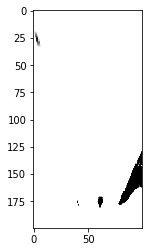

In [32]:
stream=urllib2.urlopen(hoststr)
bytes=b''
while True:
    bytes+=stream.read(1024)
    a = bytes.find(b'\xff\xd8')
    b = bytes.find(b'\xff\xd9')
    if a!=-1 and b!=-1:
        break
        
jpg = bytes[a:b+2]
bytes= bytes[b+2:]
img = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8),flags=1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = (gray<180).astype(np.uint8)*255
dst = np.array([[
    [10,200],
    [10,0],
    [90,0],
    [90,200]
]]).astype(np.float32)
M    = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_t = cv2.warpPerspective(gray, M, (100,200), cv2.WARP_INVERSE_MAP)
img_t[180:,0:10] = 255.
img_t[180:,90:]  = 255.

plt.imshow(img_t, 'gray')

In [54]:
initParams = [
        np.linspace(0.001, 0.02, 10),
        np.array(list(np.linspace(1.5, 50, 10)) + list(np.linspace(-50, 1.5, 10))),
        np.arange( 40, 50, 2),
        np.arange(-15, 15, 2)
]
refPos = [50, 180]  
seedParams = []
paramSearch = None

if len(seedParams) == 0:
    paramSearch = initParams
else:
    lla = np.linspace(seedParams[0]-(initParams[0][1]-initParams[0][0]),
                      seedParams[0]+(initParams[0][1]-initParams[0][0]), 3)
    llb = np.linspace(seedParams[1]-(initParams[1][1]-initParams[1][0]),
                      seedParams[1]+(initParams[1][1]-initParams[1][0]), 3)
    llc = np.arange(seedParams[2]-2, seedParams[2]+3, 2)
    lld = np.arange(seedParams[3]-1, seedParams[3]+2)
    paramSearch = [lla, llb, llc, lld]

coords,params = getBestParams(img_t, paramSearch, refPos)


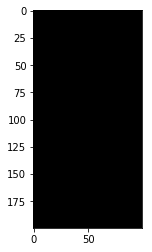

In [55]:
plt.imshow(img_t, 'gray')


(0, 100)

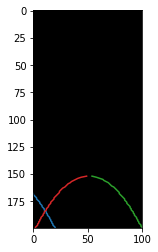

In [56]:
plt.imshow(img_t, "gray")
for i in range(4):
    plt.plot(coords[i], coords[4])
    
plt.xlim(0, 100)